## Dependencies

In [1]:
import pandas as pd
import numpy as np
import re 
import sys
import itertools

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth
import spotipy.util as util

import warnings
warnings.filterwarnings("ignore")

In [2]:
# set matplotlib to inline
%matplotlib inline

In [3]:
# Set jupyter notebook view
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

## 1. Data Preparation

In [4]:
spotify_df = pd.read_csv('data.csv')
spotify_df.head()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
0,0.0594,1921,0.982,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878000,10,0.665,-20.096,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,1921,0.0366,80.954
1,0.9630,1921,0.732,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000000,7,0.160,-12.441,1,Clancy Lowered the Boom,5,1921,0.4150,60.936
2,0.0394,1921,0.961,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913000,3,0.101,-14.850,1,Gati Bali,5,1921,0.0339,110.339
3,0.1650,1921,0.967,['Frank Parker'],0.275,210000,0.309,0,3ftBPsC5vPBKxYSee08FDH,0.000028,5,0.381,-9.316,1,Danny Boy,3,1921,0.0354,100.109
4,0.2530,1921,0.957,['Phil Regan'],0.418,166693,0.193,0,4d6HGyGT8e121BsdKmw9v6,0.000002,3,0.229,-10.096,1,When Irish Eyes Are Smiling,2,1921,0.0380,101.665


1. Data yang diatmpilkan disini untuk tingkat lagu individual
2. Tidak ada data yang berhubungan dengan genre lagu

In [5]:
data_w_genre = pd.read_csv('data_w_genres.csv')
data_w_genre.head()

,genres,artists,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count
0,['show tunes'],"""Cats"" 1981 Original London Cast",0.590111,0.467222,250318.555556,0.394003,0.011400,0.290833,-14.448000,0.210389,117.518111,0.389500,38.333333,5,1,9
1,[],"""Cats"" 1983 Broadway Cast",0.862538,0.441731,287280.000000,0.406808,0.081158,0.315215,-10.690000,0.176212,103.044154,0.268865,30.576923,5,1,26
2,[],"""Fiddler On The Roof” Motion Picture Chorus",0.856571,0.348286,328920.000000,0.286571,0.024593,0.325786,-15.230714,0.118514,77.375857,0.354857,34.857143,0,1,7
3,[],"""Fiddler On The Roof” Motion Picture Orchestra",0.884926,0.425074,262890.962963,0.245770,0.073587,0.275481,-15.639370,0.123200,88.667630,0.372030,34.851852,0,1,27
4,[],"""Joseph And The Amazing Technicolor Dreamcoat""...",0.510714,0.467143,270436.142857,0.488286,0.009400,0.195000,-10.236714,0.098543,122.835857,0.482286,43.000000,5,1,7


1. Data ini berada di tingkat artis
2. Data genre pada artis dapat digunaakan namun bentuknya masih berupa string
3. Data genre harus dirubah ke list agar dapat bisa digunakan

In [6]:
print(data_w_genre['genres'].values[0])
data_w_genre['genres'].values[0][0]

['show tunes']


'['

1. Terbukti bahwa data genre berupa string, bukan list 
2. Regex akan digunakan untuk merubah string menjadi list untuk genre

In [7]:
data_w_genre['genres_upd'] = data_w_genre['genres'].apply(lambda x: [re.sub(' ','_',i) for i in re.findall(r"'([^']*)'", x)])
data_w_genre['genres_upd'].values[0][0]

'show_tunes'

Data genre sudah berupa list.

Untuk menambahkan data genre ke lagu maka diperlukan untuk menghubungkan data genre pada level artis dengan data lagu.
1. Mengekstrak kolom artis sehingga setiap artis dalam sebuah lagu akan memiliki row masing-masing
2. Menggabungkan data_w_genre ke dataset yang sudah diekstrak

Sama dengan sebelumnya, data artist masih berupa string dan harus dirubah ke list karena ada beberapa lagu yang memiliki lebih dari satu penulis.
(cth kasus: lagu collab, featuring artist).

In [8]:
temp1 = spotify_df['artists'].apply(lambda x: re.findall(r"'([^']*)'", x))
temp2 = spotify_df['artists'].apply(lambda x: re.findall('\"(.*?)\"',x))
spotify_df['artists_upd'] = np.where(temp1.apply(lambda x: not x), temp2, temp1 )
print(spotify_df['artists'].values[0])
print(spotify_df['artists'].values[0][1])
print(spotify_df['artists_upd'].values[0][1])


['Sergei Rachmaninoff', 'James Levine', 'Berliner Philharmoniker']
'
James Levine


1. Data artist sudah berbentuk lsit
2. Masih ada data lagu yang memiliki duplikat dan harus dibersihkan

In [9]:
spotify_df['artists_song'] = spotify_df.apply(lambda row: row['artists_upd'][0]+row['name'],axis = 1)

In [10]:
spotify_df.sort_values(['artists_song','release_date'], ascending = False, inplace = True)

In [11]:
spotify_df[spotify_df['name']=='Adore You']
# contoh lagu yang memiliki duplikat

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,...,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,artists_upd,artists_song
19425,0.569,2019,0.0237,['Harry Styles'],0.676,207133,0.771,0,3jjujdWJ72nww5eGnfs2E7,0.000007,...,0.102,-3.675,1,Adore You,88,2019-12-13,0.0483,99.048,[Harry Styles],Harry StylesAdore You
38319,0.569,2019,0.0237,['Harry Styles'],0.676,207133,0.771,0,1M4qEo4HE3PRaCOM7EXNJq,0.000007,...,0.102,-3.675,1,Adore You,77,2019-12-06,0.0483,99.048,[Harry Styles],Harry StylesAdore You


In [12]:
spotify_df.drop_duplicates('artists_song',inplace = True)
spotify_df[spotify_df['name']=='Adore You']

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,...,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,artists_upd,artists_song
19425,0.569,2019,0.0237,['Harry Styles'],0.676,207133,0.771,0,3jjujdWJ72nww5eGnfs2E7,0.000007,...,0.102,-3.675,1,Adore You,88,2019-12-13,0.0483,99.048,[Harry Styles],Harry StylesAdore You


Setelah data berbentuk normal. data artis dapat diekstrak untuk digabungkan

In [13]:
artists_exploded = spotify_df[['artists_upd','id']].explode('artists_upd')

In [14]:
artists_exploded_enriched = artists_exploded.merge(data_w_genre, how = 'left', left_on = 'artists_upd',right_on = 'artists')
artists_exploded_enriched_nonnull = artists_exploded_enriched[~artists_exploded_enriched.genres_upd.isnull()]

In [15]:
artists_exploded_enriched_nonnull[artists_exploded_enriched_nonnull['id'] =='3jjujdWJ72nww5eGnfs2E7']

,artists_upd,id,genres,artists,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count,genres_upd
126973,Harry Styles,3jjujdWJ72nww5eGnfs2E7,"['pop', 'post-teen pop']",Harry Styles,0.268816,0.541462,238180.230769,0.586769,0.016809,0.156208,-6.386923,0.035888,114.687,0.406896,78.346154,5.0,1.0,52.0,"[pop, post-teen_pop]"


setelah di ekstrak, data artist akan digabungkan ke data lagu berdasarkan id lagu

In [16]:
artists_genres_consolidated = artists_exploded_enriched_nonnull.groupby('id')['genres_upd'].apply(list).reset_index()

In [17]:
artists_genres_consolidated['consolidates_genre_lists'] = artists_genres_consolidated['genres_upd'].apply(lambda x: list(set(list(itertools.chain.from_iterable(x)))))

In [18]:
artists_genres_consolidated.head()
# data yang sudah digabungkan

,id,genres_upd,consolidates_genre_lists
0,000G1xMMuwxNHmwVsBdtj1,"[[candy_pop, dance_rock, new_wave, new_wave_po...","[new_wave_pop, permanent_wave, new_wave, power..."
1,000GyYHG4uWmlXieKLij8u,"[[alternative_hip_hop, conscious_hip_hop, minn...","[minnesota_hip_hop, pop_rap, conscious_hip_hop..."
2,000Npgk5e2SgwGaIsN3ztv,"[[classic_bollywood, classic_pakistani_pop, fi...","[classic_pakistani_pop, sufi, classic_bollywoo..."
3,000ZxLGm7jDlWCHtcXSeBe,"[[boogie-woogie, piano_blues, ragtime, stride]]","[ragtime, boogie-woogie, stride, piano_blues]"
4,000jBcNljWTnyjB4YO7ojf,[[]],[]


In [19]:
# Memasukan data yang barusan diolah ke dataframe utama
spotify_df = spotify_df.merge(artists_genres_consolidated[['id','consolidates_genre_lists']], on = 'id',how = 'left')

# 2. Feature Engineering

In [20]:
# Mendapatkan tahun rilis dari lagu
spotify_df['year'] = spotify_df['release_date'].apply(lambda x: x.split('-')[0])

In [21]:
# Normalisasi data float
float_cols = spotify_df.dtypes[spotify_df.dtypes == 'float64'].index.values

In [22]:
spotify_df['popularity'].describe()

count    156607.000000
mean         31.307215
std          21.712234
min           0.000000
25%          11.000000
50%          33.000000
75%          48.000000
max         100.000000
Name: popularity, dtype: float64

In [23]:
# Merubah data popularity menjadi kelipatan 5
spotify_df['popularity_red'] = spotify_df['popularity'].apply(lambda x: int(x/5))
print(spotify_df['popularity'].head())
print(spotify_df['popularity_red'].head())

0    31
1    35
2    23
3    23
4    23
Name: popularity, dtype: int64
0    6
1    7
2    4
3    4
4    4
Name: popularity_red, dtype: int64


In [24]:
# Mengubah nilai null menjadi list kosong pada data yang sudah digabungkan (kasus tidak ada data genre)
spotify_df['consolidates_genre_lists'] = spotify_df['consolidates_genre_lists'].apply(lambda d: d if isinstance(d, list) else [])

In [25]:
spotify_df.head()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,...,mode,name,popularity,release_date,speechiness,tempo,artists_upd,artists_song,consolidates_genre_lists,popularity_red
0,0.177,1989,0.568,['조정현'],0.447,237688,0.2150,0,2ghebdwe2pNXT4eL34T7pW,0.000001,...,1,그아픔까지사랑한거야,31,1989-06-15,0.0272,71.979,[조정현],조정현그아픔까지사랑한거야,[classic_korean_pop],6
1,0.352,1992,0.381,['黑豹'],0.353,316160,0.6860,0,3KIuCzckjdeeVuswPo20mC,0.000000,...,1,DON'T BREAK MY HEART,35,1992-12-22,0.0395,200.341,[黑豹],黑豹DON'T BREAK MY HEART,"[chinese_indie_rock, chinese_indie]",7
2,0.458,1963,0.987,['黃國隆'],0.241,193480,0.0437,0,4prhqrLXYMjHJ6vpRAlasx,0.000453,...,1,藝旦調,23,1963-05-28,0.0443,85.936,[黃國隆],黃國隆藝旦調,[],4
3,0.796,1963,0.852,"['黃國隆', '王秋玉']",0.711,145720,0.1110,0,5xFXTvnEe03SyvFpo6pEaE,0.000000,...,0,草螟弄雞公,23,1963-05-28,0.0697,124.273,"[黃國隆, 王秋玉]",黃國隆草螟弄雞公,[],4
4,0.704,1963,0.771,['黃國隆'],0.610,208760,0.1750,0,6Pqs2suXEqCGx7Lxg5dlrB,0.000000,...,1,思想起,23,1963-05-28,0.0419,124.662,[黃國隆],黃國隆思想起,[],4


In [26]:
# Fungsi One-hot Encoding untuk mengeklompokan nilai yang akan digunakan nanti
def ohe_prep(df, column, new_name): 
    tf_df = pd.get_dummies(df[column])
    feature_names = tf_df.columns
    tf_df.columns = [new_name + "|" + str(i) for i in feature_names]
    tf_df.reset_index(drop = True, inplace = True)    
    return tf_df


In [27]:
#function to build entire feature set
def create_feature_set(df, float_cols):
    """
    Proses spotify df untuk membuat kumpulan fitur final yang akan digunakan untuk menghasilkan rekomendasi

    Parameter:
        df (bingkai data panda): Spotify Dataframe
        float_cols (list(str)): Daftar kolom float yang akan diskalakan
        
    Return:
        final: kumpulan fitur terakhir
    """
    
    # tfidf genre lists
    tfidf = TfidfVectorizer()
    tfidf_matrix =  tfidf.fit_transform(df['consolidates_genre_lists'].apply(lambda x: " ".join(x)))
    genre_df = pd.DataFrame(tfidf_matrix.toarray())
    genre_df.columns = ['genre' + "|" + i for i in tfidf.get_feature_names_out()]
    genre_df.reset_index(drop = True, inplace=True)
  
    year_ohe = ohe_prep(df, 'year','year') * 0.5
    popularity_ohe = ohe_prep(df, 'popularity_red','pop') * 0.15

    # scale float columns
    floats = df[float_cols].reset_index(drop = True)
    scaler = MinMaxScaler()
    floats_scaled = pd.DataFrame(scaler.fit_transform(floats), columns = floats.columns) * 0.2

    # concanenate all features
    final = pd.concat([genre_df, floats_scaled, popularity_ohe, year_ohe], axis = 1)
     
    #add song id
    final['id']=df['id'].values
    
    return final

In [28]:
complete_feature_set = create_feature_set(spotify_df, float_cols=float_cols)#.mean(axis = 0)

In [29]:
complete_feature_set.tail()

,genre|21st_century_classical,genre|432hz,genre|_hip_hop,genre|a_cappella,genre|abstract,genre|abstract_beats,genre|abstract_hip_hop,genre|accordeon,genre|accordion,genre|acid_house,...,year|2012,year|2013,year|2014,year|2015,year|2016,year|2017,year|2018,year|2019,year|2020,id
156602,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2LP2uDQQ7eLMcUVE4aOpAV
156603,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4s0o8TJHfX9LLHa0umnOzT
156604,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6YYd5MLpu45J0uLrMdivF7
156605,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3hoiinUc5VA9xUEJID7R8V
156606,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,78859Af0fmA9VTlgnOHTAP


## 3. Koneksi ke Spotify API

In [30]:
# client id and secret
with open("./.env") as f:
    f = f.read().split("\n")
    for i in range(len(f)):
        f[i] = f[i].split("=")\
        
    client_id = f[0][1]
    client_secret= f[1][1]

In [31]:
scope = 'user-library-read'

if len(sys.argv) > 1:
    username = sys.argv[1]
else:
    print("Usage: %s username" % (sys.argv[0],))
    sys.exit()

In [32]:
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(
    scope=scope, 
    client_id=client_id, 
    client_secret=client_secret, 
    redirect_uri="http://localhost:8881/"))

In [33]:
# Mendapatkan nama dan gambar playlist
id_name = {}
list_photo = {}
for i in sp.current_user_playlists()['items']:

    id_name[i['name']] = i['uri'].split(':')[2]
    list_photo[i['uri'].split(':')[2]] = i['images'][0]['url']

In [34]:
id_name

{'IR_full_set': '1OyY375OSIPp7hRzpBem7O',
 'IR_test_set': '2LTYN7uo72r4ARF7MgkoN8',
 'IR_train_set': '2pidQNzds2XvnNri2z2KV2',
 'Lovefool': '0VuHVwgDatkXrxuVMVw1iA',
 'mamamimu': '7Co22Hq1VmWD8C5wtD0iKv',
 'i love chemistry': '4nOkS4TRZ4YbbrriwM0hWo',
 'smithserpiece': '6oBihJACd0uX91nlI7AtXd',
 '2000z': '7do6sWS4mKdGel8qOioyJd',
 'ccccc': '4RSrjS5OpvZEW4W9ytWzrx',
 'saaa': '5sktSBwtTQj0c7VELPilaL',
 'mmm': '24WLzVJJzcdgFfuV30PjOV',
 'L': '02qFlio2nfaXXLXTGAo0D1',
 'aaa': '5bKZWPqU8iDyfSqz8lUtzJ',
 'Lorde': '4sHhBqvez9u2UPEUukg9gR',
 'flower face': '112pBQP2WuLDAnYaphmZRX',
 'alex turner': '5M0rg0zsj6NXBLT3UHY8w8',
 'lana del rey': '55g4PTaDxvpzmLZ4RFMovJ',
 '👑👑👑': '6GFBKcHQWoSsWYYWjbQWWr',
 'good old games': '7eul2qLxpxhTRGR3TvEovf',
 '❄⛄❄': '3peMlmqyP4xSEanCUMOl6d',
 '🎸': '1uGkHTY2nDyHlSfYIOGNor'}

In [35]:
def create_necessary_outputs(playlist_name,id_dic, df):
    """
    Tarik lagu dari playlist tertentu.

    Parameter:
        playlist_name (str): nama playlist yang ingin Anda tarik dari API spotify
        id_dic (dic): kamus yang memetakan playlist_name ke playlist_id
        df (bingkai data panda): kerangka data spotify
        
    Return:
        daftar putar: semua lagu dalam daftar putar YANG TERSEDIA di dalam DATASET
    """
    
    #generate playlist dataframe
    playlist = pd.DataFrame()
    playlist_name = playlist_name

    for ix, i in enumerate(sp.playlist(id_dic[playlist_name])['tracks']['items']):
        #print(i['track']['artists'][0]['name'])
        playlist.loc[ix, 'artist'] = i['track']['artists'][0]['name']
        playlist.loc[ix, 'name'] = i['track']['name']
        playlist.loc[ix, 'id'] = i['track']['id'] # ['uri'].split(':')[2]
        playlist.loc[ix, 'url'] = i['track']['album']['images'][1]['url']
        playlist.loc[ix, 'date_added'] = i['added_at']

    playlist['date_added'] = pd.to_datetime(playlist['date_added'])  
    
    playlist = playlist[playlist['id'].isin(df['id'].values)].sort_values('date_added',ascending = False)
    
    return playlist

In [36]:
# Playlist untuk dijadikan sampel rekomendasi
playlist_sample = create_necessary_outputs('alex turner', id_name,spotify_df)
len(playlist_sample)

12

In [51]:
playlist_sample[["name","artist"]]
# print((playlist_sample["name"]))

,name,artist
55,No. 1 Party Anthem,Arctic Monkeys
58,I Wanna Be Yours,Arctic Monkeys
41,Mad Sounds,Arctic Monkeys
40,Stop The World I Wanna Get Off With You,Arctic Monkeys
60,"Sweet Dreams, TN",The Last Shadow Puppets
20,Knee Socks,Arctic Monkeys
16,Snap Out Of It,Arctic Monkeys
19,Do I Wanna Know?,Arctic Monkeys
18,Arabella,Arctic Monkeys
17,Why'd You Only Call Me When You're High?,Arctic Monkeys


In [38]:
from skimage import io
import matplotlib.pyplot as plt

# Fungsi untuk menampilkan image lagu
def visualize_songs(df):
    """ 
    Visualize cover art of the songs in the inputted dataframe

    Parameters: 
        df (pandas dataframe): Playlist Dataframe
    """
    
    temp = df['url'].values
    plt.figure(figsize=(10,int(0.625 * len(temp))))
    columns = 5
    
    for i, url in enumerate(temp):
        plt.subplot(int(len(temp) / columns + 1), columns, i + 1)

        image = io.imread(url)
        plt.imshow(image)
        plt.xticks(color = 'w', fontsize = 0.1)
        plt.yticks(color = 'w', fontsize = 0.1)
        plt.xlabel(df['name'].values[i], fontsize = 12)
        plt.tight_layout(h_pad=0.4, w_pad=0)
        plt.subplots_adjust(wspace=None, hspace=None)

    plt.show()

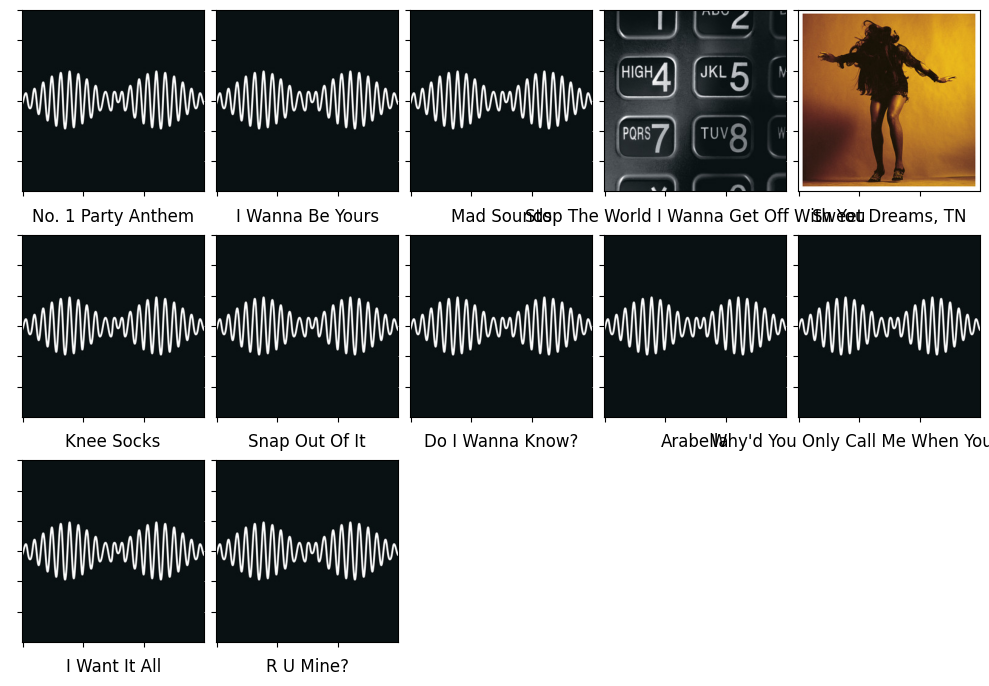

In [39]:
visualize_songs(playlist_sample)

## 4. Membuat Vektor dari Playlist

In [40]:
def generate_playlist_feature(complete_feature_set, playlist_df, weight_factor):
    """
    Ringkas daftar putar pengguna menjadi satu vektor

    Parameter:
        complete_feature_set (pandas dataframe): Dataframe yang menyertakan semua fitur untuk lagu spotify
        playlist_df (bingkai data panda): bingkai data daftar putar
        weight_factor (float): nilai float yang merepresentasikan bias keterkinian. Semakin besar bias resensi, lagu terbaru yang paling diprioritaskan. Nilai harus mendekati 1.
        
    Return:
        playlist_feature_set_weighted_final (seri panda): fitur tunggal yang merangkum playlist
        complete_feature_set_nonplaylist (bingkai data panda):
    """
    
    complete_feature_set_playlist = complete_feature_set[complete_feature_set['id'].isin(playlist_df['id'].values)]#.drop('id', axis = 1).mean(axis =0)
    complete_feature_set_playlist = complete_feature_set_playlist.merge(playlist_df[['id','date_added']], on = 'id', how = 'inner')
    complete_feature_set_nonplaylist = complete_feature_set[~complete_feature_set['id'].isin(playlist_df['id'].values)]#.drop('id', axis = 1)
    
    playlist_feature_set = complete_feature_set_playlist.sort_values('date_added',ascending=False)

    most_recent_date = playlist_feature_set.iloc[0,-1]
    
    for ix, row in playlist_feature_set.iterrows():
        playlist_feature_set.loc[ix,'months_from_recent'] = int((most_recent_date.to_pydatetime() - row.iloc[-1].to_pydatetime()).days / 30)
        
    playlist_feature_set['weight'] = playlist_feature_set['months_from_recent'].apply(lambda x: weight_factor ** (-x))
    
    playlist_feature_set_weighted = playlist_feature_set.copy()
    #print(playlist_feature_set_weighted.iloc[:,:-4].columns)
    playlist_feature_set_weighted.update(playlist_feature_set_weighted.iloc[:,:-4].mul(playlist_feature_set_weighted.weight,0))
    playlist_feature_set_weighted_final = playlist_feature_set_weighted.iloc[:, :-4]
    #playlist_feature_set_weighted_final['id'] = playlist_feature_set['id']
    
    return playlist_feature_set_weighted_final.sum(axis = 0), complete_feature_set_nonplaylist

In [41]:
complete_feature_set_playlist_vector, complete_feature_set_nonplaylist = generate_playlist_feature(complete_feature_set, playlist_sample, 1.09)
#complete_feature_set_playlist_vector_chill, complete_feature_set_nonplaylist_chill = generate_playlist_feature(complete_feature_set, playlist_chill, 1.09)

In [42]:
complete_feature_set_playlist_vector.shape

(3070,)

## 5. Membuat playlist Rekomendasi

In [43]:


def generate_playlist_recos(df, features, nonplaylist_features, amount = 20):
    """ 
    Pull songs from a specific playlist.

    Parameters: 
        df (pandas dataframe): spotify dataframe
        features (pandas series): summarized playlist feature
        nonplaylist_features (pandas dataframe): feature set of songs that are not in the selected playlist
        
    Returns: 
        non_playlist_df_top_40: Top 40 recommendations for that playlist
    """
    
    non_playlist_df = df[df['id'].isin(nonplaylist_features['id'].values)]
    non_playlist_df['sim'] = cosine_similarity(nonplaylist_features.drop('id', axis = 1).values, features.values.reshape(1, -1))[:,0]
    non_playlist_df_top_40 = non_playlist_df.sort_values('sim',ascending = False).head(amount)
    non_playlist_df_top_40['url'] = non_playlist_df_top_40['id'].apply(lambda x: sp.track(x)['album']['images'][1]['url'])
    
    return non_playlist_df_top_40

In [44]:
recommendation_result = generate_playlist_recos(
    spotify_df, 
    complete_feature_set_playlist_vector, 
    complete_feature_set_nonplaylist
)

In [50]:
recommendation_result[["name", "sim"]]

,name,sim
149458,Fireside,0.990386
149442,One For The Road,0.985438
149419,When The Sun Goes Down,0.811192
149457,Fluorescent Adolescent,0.809686
149443,Old Yellow Bricks,0.808379
149468,D Is for Dangerous,0.808120
149426,Teddy Picker,0.808111
149466,Dancing Shoes,0.807966
149431,She's Thunderstorms,0.807946
149469,Crying Lightning,0.807904


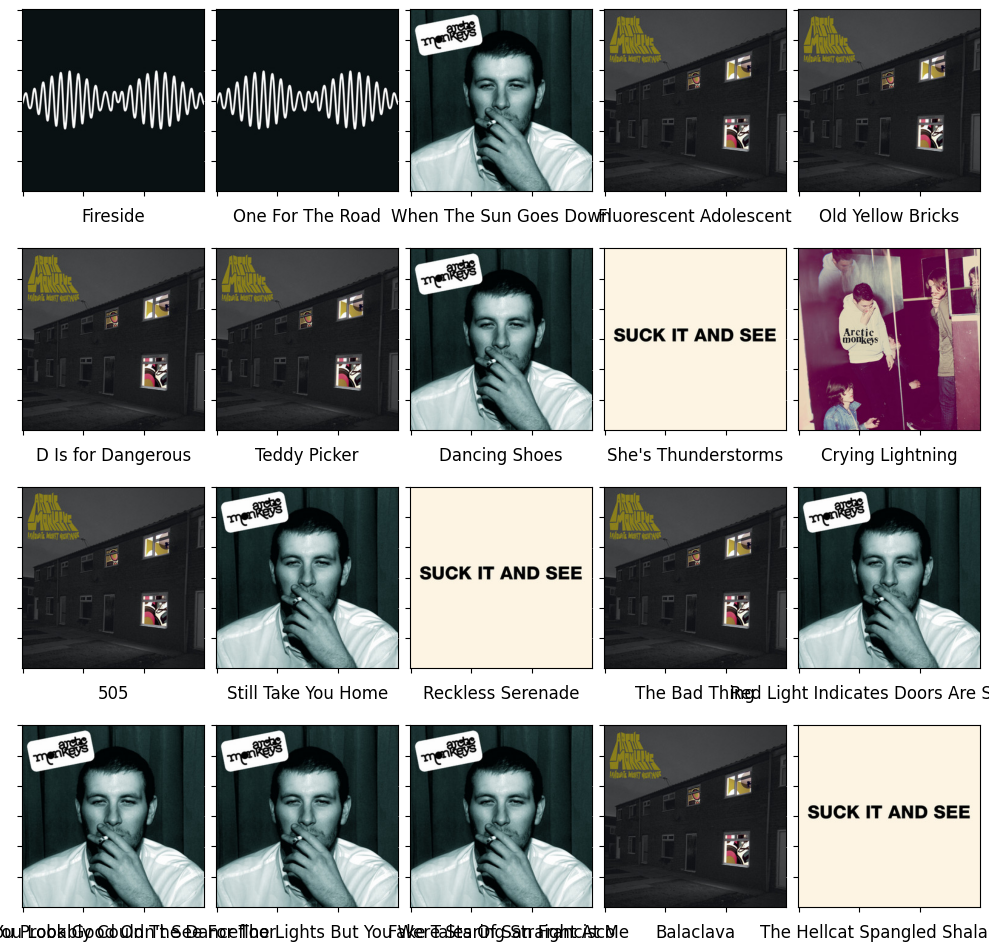

In [46]:
visualize_songs(recommendation_result)

# 6. Evaluation
Evaluasi dilakukan dengan menghitung nilai RMSE berdasarkan rating dari user testing dan cosine similarityd dari model.

User testing yang dilakukan adalah dengan memberikan playlist rekomendasi kepada user dan user akan memberikan rating terhadap lagu yang direkomendasikan.

In [47]:
# Merubah nilai rating menjadi persentasi (per 10) agar dapat dibandingkan dengan cosine similarity 

user_rating_df = pd.read_csv("./user_rating.csv")
user_rating_df["score_percent"] = user_rating_df["score"]/10
user_rating_df[["name", "score_percent"]].head()
# Rating dari user testing

,name,score_percent
0,Fireside,0.6
1,One For The Road,0.4
2,When The Sun Goes Down,0.9
3,Fluorescent Adolescent,0.9
4,Old Yellow Bricks,0.8


In [48]:
recommendation_result[["name", "sim"]].head()
# Cosine similarity dari rekomendasi

,name,sim
149458,Fireside,0.990386
149442,One For The Road,0.985438
149419,When The Sun Goes Down,0.811192
149457,Fluorescent Adolescent,0.809686
149443,Old Yellow Bricks,0.808379


In [49]:
# Evaluasi menggunakan RMSE
from sklearn.metrics import mean_squared_error

mse_score = mean_squared_error(user_rating_df["score_percent"]*10, recommendation_result["sim"]*10)
rmse_score = pow(mse_score, 0.5)

# mse_score
rmse_score

3.1130651777627905

Berdasarkan hasil evaluasi, model rekomendasi lagu memiliki `"rata-rata kesalahan"` sebesar 3.11 rating.

Model yang sepenuhnya benar memiliki error = 0. Model memilii tingkat kesalahan 3 rating (per 10 rating) dapat diartikan memiliki persentase error sebesar 30%.

Dalam artian lain, jika pada rekomendasi diperkirakan memiliki kemiripan sebesar 60% (0.6 sim), lagu tersebut pada kenyataanya dapat diberi nilai oleh user sekitar 9 rating (0.9) atau 3 rating (0.3).

Dengan itu, dapat diartikan model yang dibuat masih belum sepenuhnya akurat dalam merekomendasikan lagu berdasarkan kemiripan. Hal ini dapat disebabkan oleh dataset yang sudah lawas.